# Estimating Derivatives

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns 
plt.style.use('ggplot')

## Gen Data

In [145]:

def pendulum_actual(t, state, p):
    # state = [theta, theta_d]

    # Parameters
    mu, L = p

    # Calc derivatives
    theta_d = state[1]
    theta_dd = 9.8 * np.sin(state[0]) / L - mu * state[1]

    return np.array([theta_d, theta_dd])

# Set initial conditions and parameters
tspan = (0, 100)
tspan = (0, 10)
X0 = np.array([
    [0.524, 1.57, -1.0, -2.5, 0.0, -0.25],  # theta
    [0.0, -1.0, 1.0, 2.0, 0.5, 3.0],  # theta_d
])
X0 = np.array([[0.524], [0.0]])  # 30 degrees, at rest
p = [0.02, 1.0]

# solve ODE
t = np.linspace(*tspan, 10000)
t = np.linspace(*tspan, round(tspan[1] * 100))
# res = solve_ivp(pendulum_actual, tspan, X0, args=[p], dense_output=True)
res_list = []
noise = 1.0
empty_row = pd.DataFrame({"theta": [np.nan], "theta_d": [np.nan]})
for i in range(X0.shape[1]):
    res = solve_ivp(pendulum_actual, tspan, X0[:, i], args=[p], dense_output=True)
    curr_data = pd.DataFrame(res.sol(t).T + noise * np.random.normal(size=(t.shape[0], 2)), columns=["theta", "theta_d"])
    curr_data_ = pd.DataFrame(res.sol(t).T, columns=["theta_", "theta_d_"])
    res_list.append(pd.concat([curr_data, curr_data_], axis=1))
    res_list.append(empty_row)
data = pd.concat(res_list)
data["theta_dd_"] = [pendulum_actual(0, data[["theta_", "theta_d_"]].iloc[i].tolist(), p)[1] for i in range(len(data))]
data


,theta,theta_d,theta_,theta_d_,theta_dd_
0,1.059751,0.750780,0.524000,0.000000,4.903405
1,-0.908405,-0.306206,0.524246,0.049085,4.904507
2,-0.599007,1.067370,0.524983,0.098202,4.909777
3,0.005261,-2.665702,0.526212,0.147393,4.919211
4,2.557511,0.142355,0.527933,0.196700,4.932804
...,...,...,...,...,...
996,3.229587,6.829916,2.386569,5.136327,6.613271
997,1.574529,4.987159,2.438272,5.201091,6.234165
998,2.446822,5.936725,2.490614,5.261832,5.833223
999,3.034358,3.798505,2.543560,5.318256,5.411212


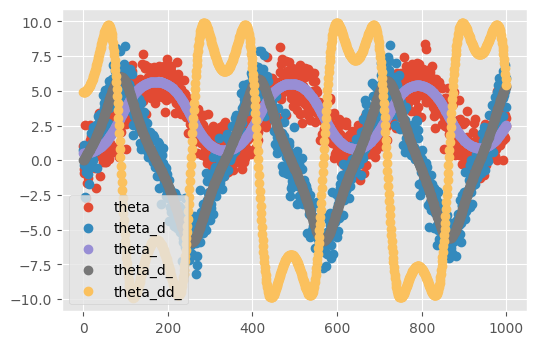

In [146]:
fig, ax = plt.subplots(dpi=100)
data.plot(ax=ax, ls="", marker="o")

plt.show()


## Smooth deriv


In [147]:
x = data.iloc[:-1].theta.to_numpy()
x_truth = data.iloc[:-1].theta_.to_numpy()
dxdt_truth = data.iloc[:-1].theta_d_.to_numpy()
ddxdt_truth = data.iloc[:-1].theta_dd_.to_numpy()
dt=0.01

RMS error in velocity:  0.4533431891934694


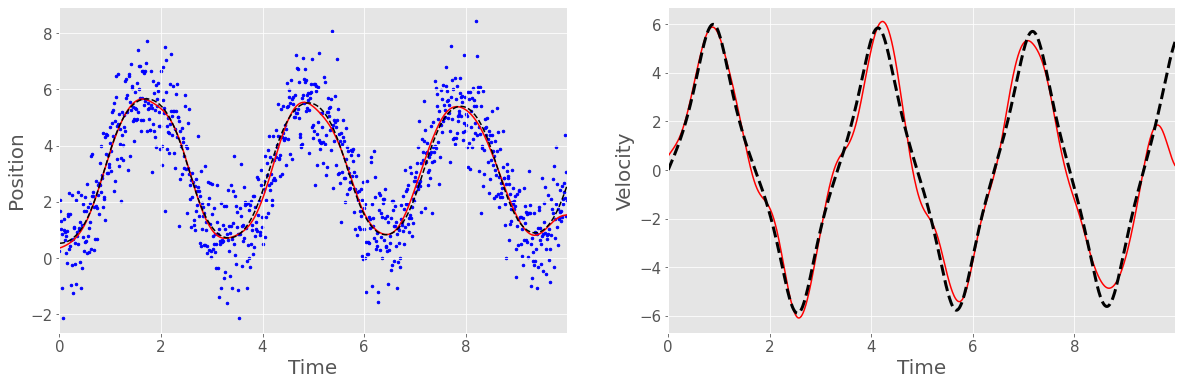

In [60]:
import pynumdiff
import pynumdiff.utils.evaluate as evaluate

params = [3, 0.02]

x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.butterdiff(x, dt, params, options={'iterate': False})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

RMS error in velocity:  73.91861533828582


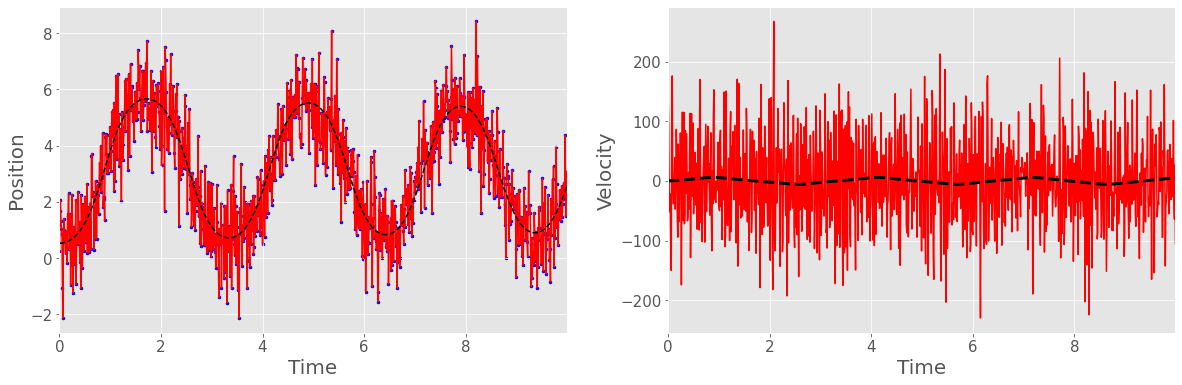

In [61]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

RMS error in velocity:  2.042839566555738


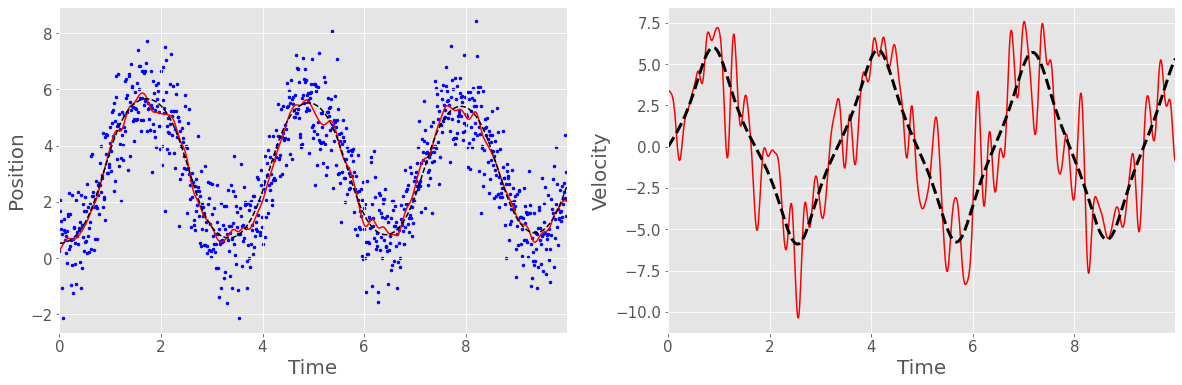

In [62]:
params = [100]
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

RMS error in velocity:  0.544925191782175


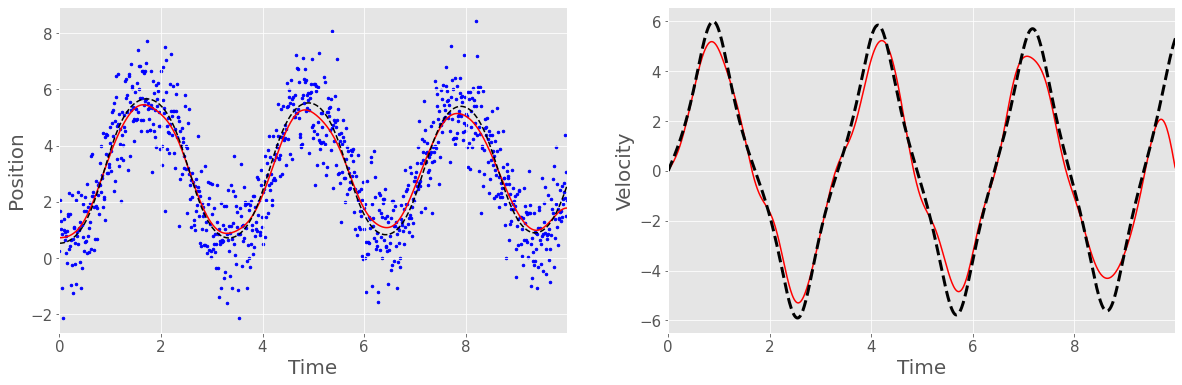

In [68]:
params = [25, 10]
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.meandiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

RMS error in velocity:  0.5309211170406588


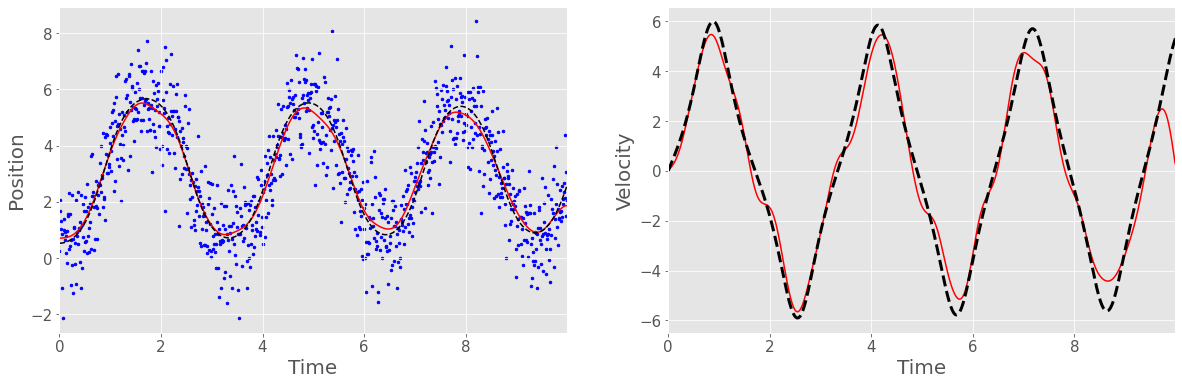

In [70]:
params = [50, 5]
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.gaussiandiff(x, dt, params, options={'iterate': True})
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## Optimizing Parameters

In [137]:
import pynumdiff.optimize

dxdt_truth_vals = None

In [149]:
cutoff_frequency = 1/3 # high frequency of signal in the data. 
# estimate by (a) counting real # peaks per second in the data or (b) look at power spectra and choose cutoff. 
log_gamma = -1.6*np.log(cutoff_frequency) -0.71*np.log(dt) - 5.1
tvgamma = np.exp(log_gamma) 
tvgamma

0.9300197038912114

RMS error in velocity:  73.11399861547223


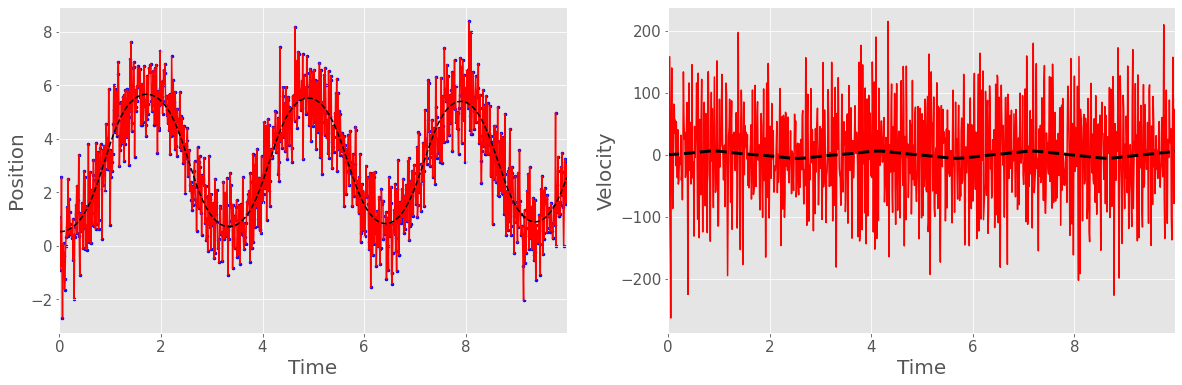

In [150]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

Optimal parameters:  [24, 5]
RMS error in velocity:  4.027770029015038


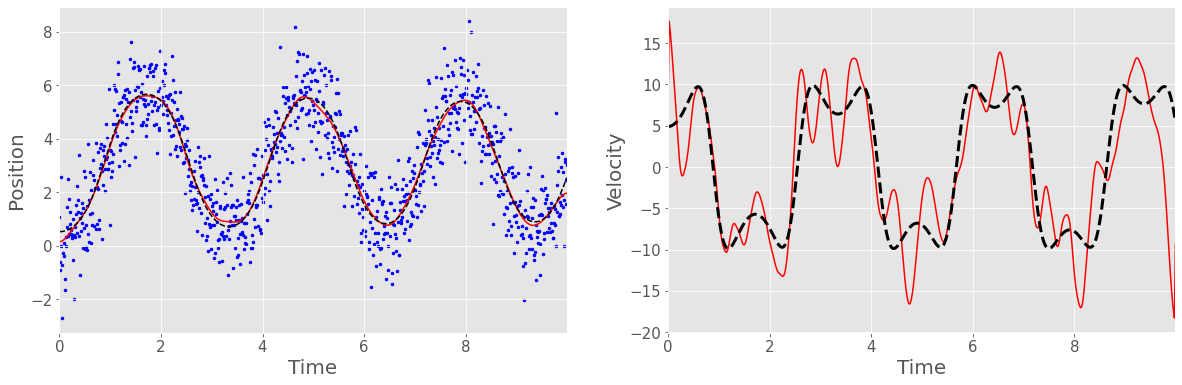

In [151]:
params, val = pynumdiff.optimize.smooth_finite_difference.meandiff(x, dt, params=None, 
                                                                   options={'iterate': True},
                                                                   tvgamma=tvgamma,
                                                                   dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.meandiff(x, dt, params, options={'iterate': True})
dxdt_hat_hat, ddxdt_hat = pynumdiff.finite_difference.first_order(dxdt_hat, dt)
evaluate.plot(x, dt, x_hat, ddxdt_hat, x_truth, ddxdt_truth)
# evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

Optimal parameters:  [41, 5]
RMS error in velocity:  2.7879410115023133


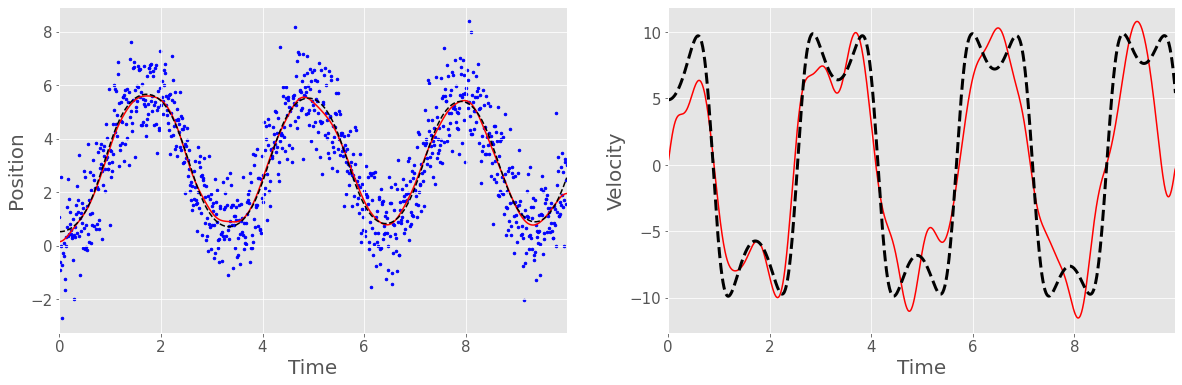

In [152]:
params, val = pynumdiff.optimize.smooth_finite_difference.gaussiandiff(x, dt, params=None, 
                                                                       options={'iterate': True},
                                                                       tvgamma=tvgamma,
                                                                       dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.gaussiandiff(x, dt, params, options={'iterate': True})
dxdt_hat_hat, ddxdt_hat = pynumdiff.smooth_finite_difference.gaussiandiff(dxdt_hat, dt, params, options={'iterate': True})
# dxdt_hat_hat, ddxdt_hat = pynumdiff.finite_difference.first_order(dxdt_hat, dt)
evaluate.plot(x, dt, x_hat, ddxdt_hat, x_truth, ddxdt_truth)
# evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

Optimal parameters:  [4, 0.015981939621913573, 1]
RMS error in velocity:  2.933899567454477


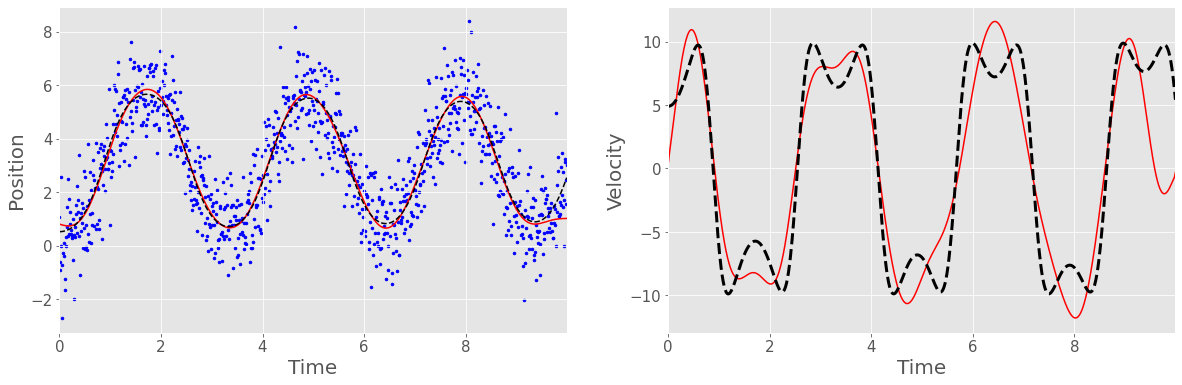

In [153]:
params, val = pynumdiff.optimize.smooth_finite_difference.butterdiff(x, dt, params=None, 
                                                                     options={'iterate': True},
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.butterdiff(x, dt, params, options={'iterate': True})
dxdt_hat_hat, ddxdt_hat = pynumdiff.finite_difference.first_order(dxdt_hat, dt)
evaluate.plot(x, dt, x_hat, ddxdt_hat, x_truth, ddxdt_truth)
# evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

Optimal parameters:  [4, 0.015981939621913573, 1]
RMS error in velocity:  3.0446605830035


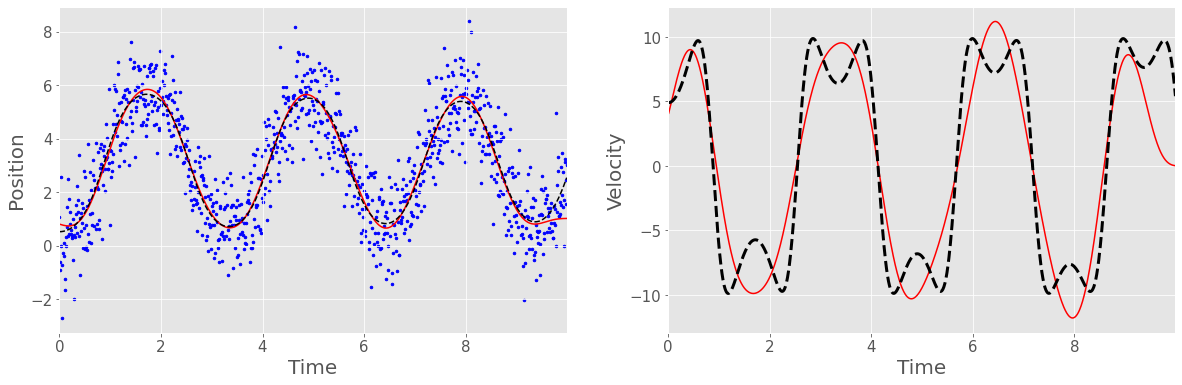

In [154]:
params, val = pynumdiff.optimize.smooth_finite_difference.butterdiff(x, dt, params=None, 
                                                                     options={'iterate': True},
                                                                     tvgamma=tvgamma,
                                                                     dxdt_truth=dxdt_truth_vals)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = pynumdiff.smooth_finite_difference.butterdiff(x, dt, params, options={'iterate': True})
dxdt_hat_hat, ddxdt_hat = pynumdiff.smooth_finite_difference.butterdiff(dxdt_hat, dt, params, options={'iterate': True})
# dxdt_hat_hat, ddxdt_hat = pynumdiff.finite_difference.first_order(dxdt_hat, dt)
evaluate.plot(x, dt, x_hat, ddxdt_hat, x_truth, ddxdt_truth)
# evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

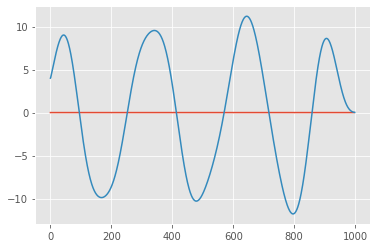

In [158]:
fig, ax = plt.subplots()
ax.plot(x_hat[2:] + x_hat[:-2] - 2 * x_hat[1:-1])
ax.plot(ddxdt_hat)